In [1]:
import pandas as pd
from tqdm import tqdm
tqdm.pandas()  # これがないと .progress_apply は使えない

In [2]:
data = pd.read_csv(r"D:\fujiwara\M\data\after_preprocess\2014-2023_受付帳_名寄せ_登記原因.csv")

C:\Users\GUESTUSER\AppData\Local\Temp\ipykernel_19340\3244177119.py:1: DtypeWarning: Columns (9,10,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(r"D:\fujiwara\M\data\after_preprocess\2014-2023_受付帳_名寄せ_登記原因.csv")


In [105]:
data.head()

,register_num,register_date,register_type,reason,pref,city,new_or_existing,type,location,chiban,...,building_area,total_floor_area,max_layout,min_layout,property_type,structure,id,line_name,station_name,on_foot
0,58,2014-01-06,連続,所有権移転・相続,青森県,三戸郡南部町,既,土地,三戸郡南部町大字高瀬字櫓長根,16-3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,諏訪ノ平,15.0
1,34,2014-01-06,連続,抹消登記,東京都,新宿区,既,区分建物,新宿区新宿7丁目,NaN,...,1262.03,4548.08,3LDK,1LDK,マンション,RC,2058261.0,東京メトロ副都心線,東新宿,3.0
2,9,2014-01-06,連先,権利の移転(所有権を除く),茨城県,結城市,既,土地,結城市大字東茂呂,673-1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,小田林,110.0
3,12,2014-01-06,連続,表示に関するその他,秋田県,鹿角市,既,建物,鹿角市十和田錦木字浜田,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,91,2014-01-06,連先,所有権移転その他の原因,東京都,板橋区,既,土地,板橋区双葉町,36-20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,中板橋,4.0


In [106]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56274675 entries, 0 to 56274674
Data columns (total 44 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   register_num             object 
 1   register_date            object 
 2   register_type            object 
 3   reason                   object 
 4   pref                     object 
 5   city                     object 
 6   new_or_existing          object 
 7   type                     object 
 8   location                 object 
 9   chiban                   object 
 10  kaoku_number             object 
 11  land_num                 object 
 12  other                    float64
 13  lat                      float64
 14  lon                      float64
 15  size                     float64
 16  building_coverage_ratio  float64
 17  floor_area_ratio         float64
 18  use_district             object 
 19  official_price           float64
 20  land_price               float64
 21  lat2  

# 登記原因が26個の内どれかであるデータのみを抽出する

In [107]:
print(len(data['reason'].unique()))
print(data["reason"].unique())

6747
['所有権移転・相続' '抹消登記' '権利の移転(所有権を除く)' ... '鍼失' '登記名義人の氏名等について-ロ号の変更・更正'
 '権利の変更更生']


In [3]:
# 主要な登記原因のリスト　25個
valid_reasons = [
    "所有権移転売買", "所有権移転相続・法人合併", "抹消登記", 
    "登記名義人の氏名等についての変更・更正", "所有権の保存(申請)", "所有権の保存(職権)", "滅失", 
    "地目変更・更正", "所有権移転遺贈・贈与その他", "分筆", "権利の変更・更正", 
    "根抵当権の設定", "所有権移転その他の原因", "権利の移転(所有権を除く)", 
    "抵当権の設定", "地積変更・更正", "区分建物の表題", "表題", "仮登記(その他)", "処分の制限に関する登記",
    "合筆", "仮登記(所有権)", "共同担保変更通知", "共同担保追加通知", "信託に関する登記"
]

other_dict = {
    "登記名義人の氏名等についての変更・更正": [
        "登記名義人の氏名等",
        '登記名義の人名氏等についての変更更正',
        '登記名義の大名氏についての変更更正',
        '登記名義人のの変更更正',
        '登記名義入の氏名等についての変更更正',
        '登記名義の人名氏についての変更更正',
        '登記名義大の氏名等についての変更更正',
        '登記名義人の変更更',
        
    ],
    
    "所有権移転相続・法人合併": [
        "所有権移転相続法人合併",
        "所有権移転・相続",
        "所有権移転/相続",
        "所有権移転相続法大合併",
        "所有権移転相続法人台併",
        "所有権移転相"
    ],
   
    "所有権移転遺贈・贈与その他": [
        "所有権移転遺贈贈与その他無償名義",
        "所有権移転/贈与",
        "無償名義",
        "遺贈",
        "贈与",
        "死因贈与",
        "所有権移転遺贈"
    ],


    "所有権の保存(申請)": [
        "所有権の保存申請",
        "所有権の保存（申請）",
        '所有権の保存(申讀)',
        '所有権の保存、(申請)',
        '所有権の保存(申',
        '所有権の保存請',
        '所有権の保存(請)',
        '所有権の保存(巾睛)',
        '所有権の保存(巾請)',
        '所有権の保存:(申請)',
        '所所権の保存(申請)',
        '所有権の保存(中請)',
        '所有権の保存中請',
        '所有権の保存_申請',
        '所有権の保存-(申請)',
        
        
        
    ],

    "所有権の保存(職権)": [
        "所有権の保存（職権）",
        "所有権の保存職権",
        '所有権の保存(戦権)'
        '所有権の保存(職權)',
        '所有権の保存',
        '所有権の保',
    
    ],
    
    "権利の移転(所有権を除く)": [
        "権利の移転",
        '権利移転所有権を除く'
        
    ],
    "仮登記(その他)": [
        "仮登記その他",
        "仮登記（その他）",
        "仮登記:(その他)",
        "仮登記:（その他）",
        '仮登記(ぞの他)' ,
        '収登記(その他)',
        
        
    ],
    "仮登記(所有権)": [
        "仮登記",
    ],
    
    "地積変更・更正": [
        "地積変更",
        '地変更更正',
        '地獄変更更正',
        '地震変更更正',
        
    ],

    "地目変更・更正": [
        "地自変更",
        "地目変更",
        '地且変更',
        '地日変更',
        '地月変更更正',
        '地変変更更正',
    ],

    "権利の変更・更正": [
        "権利の変更",
        "権利変更更正",
        'の変更・更正',
        'の変更更正',
        '権利変変更正',



    ],
    
    "信託に関する登記": [
        "託に関する登記"
    ],

    "滅失": [
        "鍼失",
        "失",
        "減滅",
        "誠夫",
        '滅',
        '誠矢',
        
        

        
    ],
    
    "所有権移転その他の原因": [
        "所有権移転/その他",
        '所有権移転ぞの他の原',
        '所有権移転その',
        '所所権移転その他の原因',
        '所有物移転その他の原因',

    ],
    
    
    "所有権移転売買": [
        '所有権移転',

        
        
    ],

    "分筆": [
        "分",
        '台筆',

    ],
    "合筆": [
        '合',
        '含筆',
        
        
        
    ],

    "抹消登記": [
        "抹茶登記",
        "抹登記",
        '消',
        '抹清登記',
        '枋寮登記',
        '末梢登記',

    ],

    "表題": [
        "裏題",
        "夜題",
        "裴題",
        '衷題',
        '表告',
        '喪題',
        '変題',
        '表明',
        '寝題',
        '表麗',
        '表選',
        '襄題',
        '裹題',
        '表',
        '題',
        '衰題',
          
    ],
    
    "根抵当権の設定": [
        '根',
    ],

    "抵当権の設定": [
        '抵抵権権設定',
        '抵抵権の設定',
        '抵抵権権の設定',
        '抵尚権の設定',
        '当当の設定',
        '抵',
        '抵当権の設',
        


    ],
    
    "共同担保変更通知": [
        "共同担保変更道知",

    ]
    
}


# 無視したい "どうでもいい理由"
ignore_reasons = [
    '表示に関するその他', '買戻権', '権利に関するその他', '配偶者居住権の設定', '分割・区分', '地上権の設定', '床面積の変更', '附属建物の新築', '敷地権の表示', '建物所在図訂正', 
    '地役権の設定', '賃借権の設定', '土地改良区画整理', '合併', '合体', '先取特権の保存', '質権の設定', '移記', '敷地権たる旨の登記', '#NAME?', 'nan', '筆界特定に伴う地図番号欄への記載',
    '地図訂正', '採石権の設定', '郵送', '予告登記', '地上欄の設定', '永小作権の設定', '買房権', '飯豊記(所有権)', '地上榴の設定', '衰期', '増役権の設定', '取下' '却下', 
]

In [4]:
# 登記原因の名寄せ

reverse_dict = {}
for norm, variants in other_dict.items():
    for variant in variants:
        reverse_dict[variant] = norm

def map_reason(value):
    for variant in reverse_dict:
        if variant in value:
            return reverse_dict[variant]
    for reason in valid_reasons:
        if reason in value:
            return reason
    return value

# tqdmを使って途中経過を表示しながら適用
data['reason'] = data['reason'].astype(str).progress_apply(map_reason)

100%|██████████| 56274675/56274675 [01:44<00:00, 541054.47it/s]


In [5]:
# 条件を満たすブールマスク
mask = data["reason"].apply(
    lambda x: (
        not any(valid in x for valid in valid_reasons) and 
        not any(ignore in x for ignore in ignore_reasons)
    )
)

# 上記の条件を満たすユニークな理由を表示
unmatched_reasons = data.loc[mask, "reason"].unique()

# 結果出力
print(f"Unmatched Reason Count: {len(unmatched_reasons)}")
print(unmatched_reasons)

Unmatched Reason Count: 54
['取下' '却下' '清登記' '*' '敷地橦たる旨の登記' '敷地榴たる旨の登記' '地土権の設定' '登記(支払の登録)' '所' '附'
 'の' '登の' '所有' '抹' '戸' '地' '所無' 'お' '年' 'P' '権' '仮' '3' '城' '岡オン' '威'
 '附属建物の新' '房' '登の3' '土地' '登記の変' '地目' '登言の' '月' '円' '所0' '処0' '戸(' 'タ' '所希'
 '担' '80' '所1' '100' '所9' '区' '0' '尸' '附属建物の新調査士報告' 'わ' '信' '筆/オン'
 '地役権設設定' ']']


In [5]:
# valid_reasonのみを抽出，名寄せをやり切った最後に実行
data = data[data['reason'].isin(valid_reasons)]

In [7]:
print(len(data['reason'].unique()))
data['reason'].unique()

23


array(['所有権移転相続・法人合併', '抹消登記', '権利の移転(所有権を除く)', '表題', '所有権移転その他の原因',
       '地積変更・更正', '滅失', '分筆', '抵当権の設定', '所有権の保存(申請)',
       '登記名義人の氏名等についての変更・更正', '権利の変更・更正', '所有権移転売買', '合筆',
       '所有権移転遺贈・贈与その他', '地目変更・更正', '仮登記(所有権)', '仮登記(その他)', '共同担保追加通知',
       '信託に関する登記', '所有権の保存(職権)', '共同担保変更通知', '根抵当権の設定'], dtype=object)

In [8]:
data['reason'].value_counts()

reason
所有権移転売買                9847866
抹消登記                   8667931
抵当権の設定                 8641227
所有権移転相続・法人合併           6632455
登記名義人の氏名等についての変更・更正    5220641
表題                     3667266
所有権の保存(申請)             3370734
分筆                     2078880
地目変更・更正                1346339
権利の変更・更正               1305259
所有権移転遺贈・贈与その他          1124770
滅失                     1044221
権利の移転(所有権を除く)           879533
所有権移転その他の原因             793859
地積変更・更正                 450288
合筆                      280770
仮登記(所有権)                279323
仮登記(その他)                136430
共同担保変更通知                114576
信託に関する登記                 65040
共同担保追加通知                 61645
所有権の保存(職権)                2833
根抵当権の設定                     12
Name: count, dtype: int64

## 登記原因のグルーピング

In [6]:
# もう一回やるときはここで英語にしておく
# suffix_map = {
#     "売買": "sale",
#     "相続・贈与等の所有権移転": "inheritance_or_gift_transfer",
#     "担保関連": "collateral",
#     "所有権の起点": "ownership_origin",
#     "物理的変更": "physical_change",
#     "表題登記": "title_registration",
#     "制限関連": "restriction",
#     "名義・権利修正": "title_or_right_correction",
#     "抹消": "cancellation"
# }
reason_map = {
    '所有権移転売買': 'sale',
    '所有権移転相続・法人合併': "inheritance_or_gift_transfer",
    # '所有権移転遺贈・贈与その他無償名義': "inheritance_or_gift_transfer",
    '所有権移転遺贈・贈与その他': "inheritance_or_gift_transfer",
    '所有権移転その他の原因': "other_causes_transfer",
    '抵当権の設定': 'collateral',
    '根抵当権の設定': 'collateral',
    '仮登記(その他)': 'collateral',
    '仮登記(所有権)': 'collateral',
    '共同担保追加通知': 'collateral',
    '共同担保変更通知': 'collateral',
    '所有権の保存(申請)': 'ownership_origin',
    '所有権の保存(職権)': 'ownership_origin',
    '地目変更・更正': 'physical_change',
    '地積変更・更正': 'physical_change',
    '分筆': 'physical_change',
    '合筆': 'physical_change',
    '滅失': 'physical_change',
    '表題': 'title_registration',
    # "区分建物の表題": 'title_registration',
    '処分の制限に関する登記': 'restriction',
    # '処分の制限に関する登記/嘱託': 'restriction',
    '信託に関する登記': 'restriction',
    '登記名義人の氏名等についての変更・更正': 'title_or_right_correction',
    '権利の変更・更正': 'title_or_right_correction',
    '権利の移転(所有権を除く)': 'title_or_right_correction',
    '抹消登記': 'cancellation',
    # '抹消登記/嘱託': 'cancellation'
}

data['reason_group'] = data['reason'].map(reason_map).fillna('other')

In [10]:
data.head()

,register_num,register_date,register_type,reason,pref,city,new_or_existing,type,location,chiban,...,total_floor_area,max_layout,min_layout,property_type,structure,id,line_name,station_name,on_foot,reason_group
0,58,2014-01-06,連続,所有権移転相続・法人合併,青森県,三戸郡南部町,既,土地,三戸郡南部町大字高瀬字櫓長根,16-3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,諏訪ノ平,15.0,inheritance_or_gift_transfer
1,34,2014-01-06,連続,抹消登記,東京都,新宿区,既,区分建物,新宿区新宿7丁目,NaN,...,4548.08,3LDK,1LDK,マンション,RC,2058261.0,東京メトロ副都心線,東新宿,3.0,cancellation
2,9,2014-01-06,連先,権利の移転(所有権を除く),茨城県,結城市,既,土地,結城市大字東茂呂,673-1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,小田林,110.0,title_or_right_correction
3,12,2014-01-06,連続,表題,秋田県,鹿角市,既,建物,鹿角市十和田錦木字浜田,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,title_registration
4,91,2014-01-06,連先,所有権移転その他の原因,東京都,板橋区,既,土地,板橋区双葉町,36-20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,中板橋,4.0,other_causes_transfer


In [7]:
print(len(data))
data["reason_group"].value_counts()

56011898


reason_group
sale                            9847866
collateral                      9233213
cancellation                    8667931
inheritance_or_gift_transfer    7757225
title_or_right_correction       7405433
physical_change                 5200498
title_registration              3667266
ownership_origin                3373567
other_causes_transfer            793859
restriction                       65040
Name: count, dtype: int64

# datetime型に変換する

In [8]:
import datetime
data['register_date'] = pd.to_datetime(data['register_date'])

In [13]:
print(data['register_date'].min())
print(data['register_date'].max())

2014-01-06 00:00:00
2023-12-28 00:00:00


# 用途地域を英語に変換する

In [9]:
district_translation = {
    "第二種住居地域": "category_ii_residential_district",
    "第二種中高層住居専用地域": "category_ii_mid_high_rise_residential_district",
    "第一種住居地域": "category_i_residential_district",
    "準住居地域": "semi_residential_district",
    "工業地域": "industrial_district",
    "近隣商業地域": "neighborhood_commercial_district",
    "第一種低層住居専用地域": "category_i_low_rise_exclusive_residential_district",
    "第一種中高層住居専用地域": "category_i_mid_high_rise_residential_district",
    "工業専用地域": "exclusively_industrial_district",
    "準工業地域": "quasi_industrial_district",
    "第二種低層住居専用地域": "category_ii_low_rise_exclusive_residential_district",
    "商業地域": "commercial_district"
}
# 用途地域をsnake_caseの英語ラベルに変換（列を上書き）
data['use_district'] = data['use_district'].map(district_translation)

# 登記間隔日数を計算

In [15]:
data.columns

Index(['register_num', 'register_date', 'register_type', 'reason', 'pref',
       'city', 'new_or_existing', 'type', 'location', 'chiban', 'kaoku_number',
       'land_num', 'other', 'lat', 'lon', 'size', 'building_coverage_ratio',
       'floor_area_ratio', 'use_district', 'official_price', 'land_price',
       'lat2', 'lon2', 'property_name', 'address', 'min_exclusive_area',
       'max_exclusive_area', 'build_date', 'total_units', 'ground_floors',
       'underground_floors', 'parking_spaces', 'main_direction', 'land_area',
       'building_area', 'total_floor_area', 'max_layout', 'min_layout',
       'property_type', 'structure', 'id', 'line_name', 'station_name',
       'on_foot', 'reason_group'],
      dtype='object')

## chibanとland_numを統合する

In [10]:
# chiban と land_num を統合した新しい列 parcel_num を作成
data["parcel_num"] = data["chiban"].fillna(data["land_num"])

## 住所のキーを作成

In [11]:
# NaNの除去
data = data[~data["pref"].isna()]
data = data[~data["city"].isna()]
data = data[~data["location"].isna()]

# "不明" や 空文字列の除去（.any(axis=1) は不要）
data = data[~data["pref"].isin(["不明", ""])]
data = data[~data["city"].isin(["不明", ""])]
data = data[~data["location"].isin(["不明", ""])]

# 住所キー
data["address_group"] = data["pref"] + "_" + data["city"] + "_" + data["location"]

# 地番キー（parcel_num）も使って group_key 作成
data["group_key"] = data["address_group"] + "_" + data["parcel_num"].astype(str)

# 同日の登記はセット．その日あった登記原因の1-hotの算出，直後にあった登記原因の1-hotを算出，直後の登記までの日数も算出する

## 土地

In [12]:
# 売買データを取得
land_data = data[data["type"] == "土地"].copy()

In [13]:
# 登記回数（その group_key・日付の件数）
land_data['same_day_count'] = land_data.groupby(['group_key', 'register_date'])['reason'].transform('count')

In [14]:
land_data.sort_values(by=["group_key", "register_date"], inplace=True)
land_data.reset_index(drop=True, inplace=True)

In [15]:
# reason_groupをone-hot化
reason_dummies = pd.get_dummies(land_data['reason_group'], prefix='on_day_reason_group')

# one-hot付きデータ
land_data_with_dummies = pd.concat([land_data[['group_key', 'register_date']], reason_dummies], axis=1)

# group_key × 登記日で1レコードに統合（複数の登記原因が同日あればmaxで1）
dummies_grouped = land_data_with_dummies.groupby(['group_key', 'register_date'], as_index=False).max()

# land_dataから代表行（group_key × 登記日で1件）を取得（他の列を残す）
# ここでは先頭の行を代表として抽出
meta_cols = [col for col in land_data.columns if col not in ['reason', 'reason_group', 'register_type', 'register_num']]
meta_grouped = land_data[meta_cols].drop_duplicates(subset=['group_key', 'register_date'])

# 結合：one-hotと他の列を統合
land_data_daily = pd.merge(meta_grouped, dummies_grouped, on=['group_key', 'register_date'], how='left')

# on_day_reason_group_ で始まる列を抽出して int に変換
reason_group_cols = [col for col in land_data_daily.columns if col.startswith('on_day_reason_group_')]
land_data_daily[reason_group_cols] = land_data_daily[reason_group_cols].astype(int)

In [16]:
land_data_daily.head()

,register_date,pref,city,new_or_existing,type,location,chiban,kaoku_number,land_num,other,...,on_day_reason_group_cancellation,on_day_reason_group_collateral,on_day_reason_group_inheritance_or_gift_transfer,on_day_reason_group_other_causes_transfer,on_day_reason_group_ownership_origin,on_day_reason_group_physical_change,on_day_reason_group_restriction,on_day_reason_group_sale,on_day_reason_group_title_or_right_correction,on_day_reason_group_title_registration
0,2023-01-27,三重県,いなべ市,既,土地,いなべ市北勢町下平,NaN,NaN,1047-1,1.0,...,0,0,0,0,0,1,0,0,0,0
1,2023-02-22,三重県,いなべ市,既,土地,いなべ市北勢町下平,NaN,NaN,1047-1,NaN,...,0,0,0,0,0,0,0,1,0,0
2,2023-02-28,三重県,いなべ市,既,土地,いなべ市北勢町下平,NaN,NaN,1047-3,NaN,...,0,0,1,0,0,0,0,0,0,0
3,2023-03-13,三重県,いなべ市,既,土地,いなべ市北勢町下平,NaN,NaN,1047-3,NaN,...,0,0,0,0,0,1,0,0,0,0
4,2022-02-01,三重県,いなべ市,既,土地,いなべ市北勢町下平,NaN,NaN,1220,1.0,...,0,0,0,0,0,0,0,1,0,0


In [17]:
# ステップ 1: 登記日ソート
land_data_daily.sort_values(by=['group_key', 'register_date'], inplace=True)

# ステップ 2: 次の登記日の取得
land_data_daily['next_date'] = land_data_daily.groupby('group_key')['register_date'].shift(-1)

# ステップ 3: 登記日その日の one-hot を lookup 用に保存
reason_group_cols = [col for col in land_data_daily.columns if col.startswith('on_day_reason_group_')]

lookup_onehot = land_data_daily[['group_key', 'register_date'] + reason_group_cols].copy()
lookup_onehot = lookup_onehot.rename(columns={'register_date': 'next_date'})

# ステップ 4: merge によって次の登記日の one-hot を付与
land_data_daily = pd.merge(
    land_data_daily,
    lookup_onehot,
    on=['group_key', 'next_date'],
    how='left',
    suffixes=('', '_next')
)

# ステップ 5: 登記までの日数も計算
land_data_daily['days_until_next'] = (land_data_daily['next_date'] - land_data_daily['register_date']).dt.days

In [18]:
print(max(land_data_daily['on_day_reason_group_sale']))
print(len(land_data_daily))
land_data_daily.columns

1
16868447


Index(['register_date', 'pref', 'city', 'new_or_existing', 'type', 'location',
       'chiban', 'kaoku_number', 'land_num', 'other', 'lat', 'lon', 'size',
       'building_coverage_ratio', 'floor_area_ratio', 'use_district',
       'official_price', 'land_price', 'lat2', 'lon2', 'property_name',
       'address', 'min_exclusive_area', 'max_exclusive_area', 'build_date',
       'total_units', 'ground_floors', 'underground_floors', 'parking_spaces',
       'main_direction', 'land_area', 'building_area', 'total_floor_area',
       'max_layout', 'min_layout', 'property_type', 'structure', 'id',
       'line_name', 'station_name', 'on_foot', 'parcel_num', 'address_group',
       'group_key', 'same_day_count', 'on_day_reason_group_cancellation',
       'on_day_reason_group_collateral',
       'on_day_reason_group_inheritance_or_gift_transfer',
       'on_day_reason_group_other_causes_transfer',
       'on_day_reason_group_ownership_origin',
       'on_day_reason_group_physical_change',
     

In [19]:
land_data_daily.head()

,register_date,pref,city,new_or_existing,type,location,chiban,kaoku_number,land_num,other,...,on_day_reason_group_collateral_next,on_day_reason_group_inheritance_or_gift_transfer_next,on_day_reason_group_other_causes_transfer_next,on_day_reason_group_ownership_origin_next,on_day_reason_group_physical_change_next,on_day_reason_group_restriction_next,on_day_reason_group_sale_next,on_day_reason_group_title_or_right_correction_next,on_day_reason_group_title_registration_next,days_until_next
0,2023-01-27,三重県,いなべ市,既,土地,いなべ市北勢町下平,NaN,NaN,1047-1,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,26.0
1,2023-02-22,三重県,いなべ市,既,土地,いなべ市北勢町下平,NaN,NaN,1047-1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-02-28,三重県,いなべ市,既,土地,いなべ市北勢町下平,NaN,NaN,1047-3,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,13.0
3,2023-03-13,三重県,いなべ市,既,土地,いなべ市北勢町下平,NaN,NaN,1047-3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-02-01,三重県,いなべ市,既,土地,いなべ市北勢町下平,NaN,NaN,1220,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
land_data.head()

,register_num,register_date,register_type,reason,pref,city,new_or_existing,type,location,chiban,...,structure,id,line_name,station_name,on_foot,reason_group,parcel_num,address_group,group_key,same_day_count
0,905,2023-01-27,単独,分筆,三重県,いなべ市,既,土地,いなべ市北勢町下平,NaN,...,NaN,NaN,NaN,NaN,NaN,physical_change,1047-1,三重県_いなべ市_いなべ市北勢町下平,三重県_いなべ市_いなべ市北勢町下平_1047-1,1
1,1938,2023-02-22,単独,所有権移転売買,三重県,いなべ市,既,土地,いなべ市北勢町下平,NaN,...,NaN,NaN,NaN,NaN,NaN,sale,1047-1,三重県_いなべ市_いなべ市北勢町下平,三重県_いなべ市_いなべ市北勢町下平_1047-1,1
2,2203,2023-02-28,単独,所有権移転遺贈・贈与その他,三重県,いなべ市,既,土地,いなべ市北勢町下平,NaN,...,NaN,NaN,NaN,NaN,NaN,inheritance_or_gift_transfer,1047-3,三重県_いなべ市_いなべ市北勢町下平,三重県_いなべ市_いなべ市北勢町下平_1047-3,1
3,2838,2023-03-13,単独,地目変更・更正,三重県,いなべ市,既,土地,いなべ市北勢町下平,NaN,...,NaN,NaN,NaN,NaN,NaN,physical_change,1047-3,三重県_いなべ市_いなべ市北勢町下平,三重県_いなべ市_いなべ市北勢町下平_1047-3,1
4,1195,2022-02-01,単独,所有権移転売買,三重県,いなべ市,既,土地,いなべ市北勢町下平,NaN,...,NaN,NaN,NaN,NaN,NaN,sale,1220,三重県_いなべ市_いなべ市北勢町下平,三重県_いなべ市_いなべ市北勢町下平_1220,1


In [21]:
# land_data_daily を CSV に保存
csv_file_path = r"D:\fujiwara\M\data\after_preprocess\land_data_daily.csv"
land_data_daily.to_csv(csv_file_path, index=False)

# 確認

In [11]:
land_data_daily = pd.read_csv(r"D:\fujiwara\M\data\after_preprocess\land_data_daily.csv")

C:\Users\GUESTUSER\AppData\Local\Temp\ipykernel_17720\3754770459.py:1: DtypeWarning: Columns (6,15,39) have mixed types. Specify dtype option on import or set low_memory=False.
  land_data_daily = pd.read_csv(r"D:\fujiwara\M\data\after_preprocess\land_data_daily.csv")


In [24]:
import pandas as pd

# 対象列を抽出
target_cols = [col for col in land_data_daily.columns
               if col.startswith("on_day_reason_group") and not col.endswith("_next")]

# 値が1.0の列が2つ以上ある行を抽出
multi_ones_mask = (land_data_daily[target_cols] == 1.0).sum(axis=1) >= 2
df_multi = land_data_daily.loc[multi_ones_mask, target_cols]

# 共起行列を作成
co_occurrence = pd.DataFrame(0, index=target_cols, columns=target_cols)

for _, row in df_multi.iterrows():
    active = row[row == 1.0].index
    for i in active:
        for j in active:
            if i != j:
                co_occurrence.loc[i, j] += 1

# 結果を表示（必要なら保存やプロットも可能）
print(co_occurrence)

                                                  on_day_reason_group_cancellation  \
on_day_reason_group_cancellation                                                 0   
on_day_reason_group_collateral                                              663817   
on_day_reason_group_inheritance_or_gift_transfer                            103938   
on_day_reason_group_ownership_origin                                           163   
on_day_reason_group_physical_change                                           1921   
on_day_reason_group_restriction                                               2255   
on_day_reason_group_sale                                                    708101   
on_day_reason_group_title_or_right_correction                               511861   
on_day_reason_group_title_registration                                          38   

                                                  on_day_reason_group_collateral  \
on_day_reason_group_cancellation                       

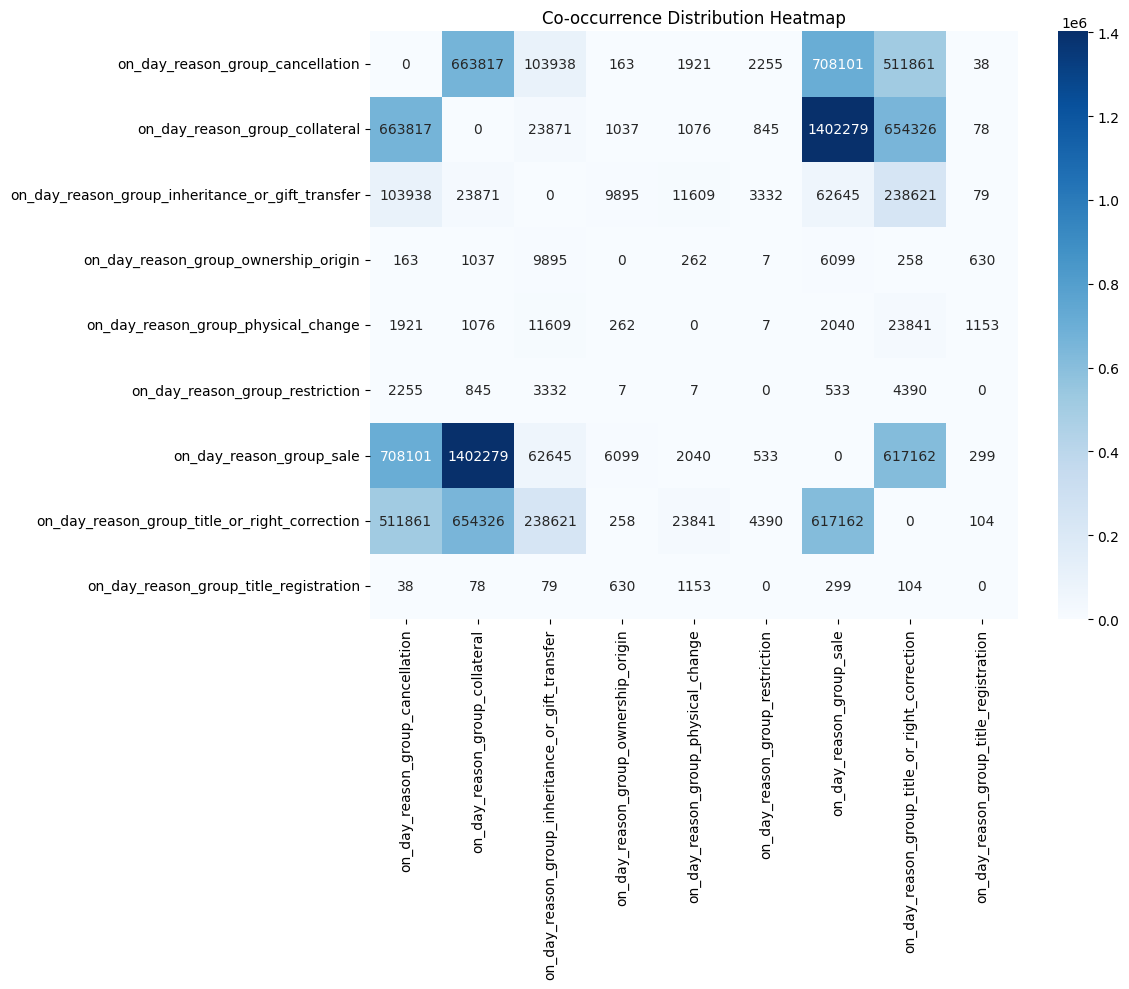

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# ヒートマップのプロット
plt.figure(figsize=(12, 10))
sns.heatmap(co_occurrence, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title("Co-occurrence Distribution Heatmap")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
land_data_daily["on_day_reason_group_sale"].sum()

np.int64(4494727)

In [26]:
import pandas as pd
from collections import Counter

# 対象列の抽出
target_cols = [col for col in land_data_daily.columns
               if col.startswith("on_day_reason_group") and not col.endswith("_next")]

# 3つ以上の列で1.0が立っている行を抽出
multi_mask = (land_data_daily[target_cols] == 1.0).sum(axis=1) >= 3
df_multi = land_data_daily.loc[multi_mask, target_cols]

# 共起パターンの集計
co_occurrence_counter = Counter()

for _, row in df_multi.iterrows():
    active = tuple(sorted(row[row == 1.0].index))
    co_occurrence_counter[active] += 1

# 結果をDataFrameに変換してソート
co_occurrence_df = pd.DataFrame([
    {"pattern": ", ".join(pattern), "count": count}
    for pattern, count in co_occurrence_counter.items()
]).sort_values(by="count", ascending=False)

# 結果表示
print(co_occurrence_df)


                                               pattern   count
4    on_day_reason_group_cancellation, on_day_reaso...  364095
3    on_day_reason_group_collateral, on_day_reason_...  107622
6    on_day_reason_group_cancellation, on_day_reaso...   75664
0    on_day_reason_group_cancellation, on_day_reaso...   58878
7    on_day_reason_group_cancellation, on_day_reaso...   46195
..                                                 ...     ...
114  on_day_reason_group_collateral, on_day_reason_...       1
115  on_day_reason_group_cancellation, on_day_reaso...       1
116  on_day_reason_group_inheritance_or_gift_transf...       1
117  on_day_reason_group_ownership_origin, on_day_r...       1
118  on_day_reason_group_cancellation, on_day_reaso...       1

[119 rows x 2 columns]


In [ ]:
# 上位5件を折り返して表示
for i, row in co_occurrence_df.head(5).iterrows():
    print(f"Pattern {i+1}:\n{row['pattern']}\nCount: {row['count']}\n{'-'*40}")

Pattern 5:
on_day_reason_group_cancellation, on_day_reason_group_collateral, on_day_reason_group_sale
Count: 364008
----------------------------------------
Pattern 4:
on_day_reason_group_collateral, on_day_reason_group_sale, on_day_reason_group_title_or_right_correction
Count: 106367
----------------------------------------
Pattern 7:
on_day_reason_group_cancellation, on_day_reason_group_collateral, on_day_reason_group_sale, on_day_reason_group_title_or_right_correction
Count: 73106
----------------------------------------
Pattern 1:
on_day_reason_group_cancellation, on_day_reason_group_collateral, on_day_reason_group_title_or_right_correction
Count: 56125
----------------------------------------
Pattern 8:
on_day_reason_group_cancellation, on_day_reason_group_sale, on_day_reason_group_title_or_right_correction
Count: 44297
----------------------------------------


# 登記原因を英語にRename

In [12]:
rename_dict = {}
suffix_map = {
    "売買": "sale",
    "相続・贈与等の所有権移転": "inheritance_or_gift_transfer",
    "担保関連": "collateral",
    "所有権の起点": "ownership_origin",
    "物理的変更": "physical_change",
    "表題登記": "title_registration",
    "制限関連": "restriction",
    "名義・権利修正": "title_or_right_correction",
    "抹消": "cancellation"
}

for col in land_data_daily.columns:
    if col.startswith("on_day_reason_group_"):
        for jp, en in suffix_map.items():
            # 通常の末尾
            if col.endswith(jp):
                new_col = col.replace(jp, en)
                rename_dict[col] = new_col
                break
            # _next が付く末尾
            elif col.endswith(jp + "_next"):
                new_col = col.replace(jp + "_next", en + "_next")
                rename_dict[col] = new_col
                break

# リネームの適用
land_data_daily = land_data_daily.rename(columns=rename_dict)


In [13]:
land_data_daily.columns

Index(['register_date', 'pref', 'city', 'new_or_existing', 'type', 'location',
       'chiban', 'kaoku_number', 'land_num', 'other', 'lat', 'lon', 'size',
       'building_coverage_ratio', 'floor_area_ratio', 'use_district',
       'official_price', 'land_price', 'lat2', 'lon2', 'property_name',
       'address', 'min_exclusive_area', 'max_exclusive_area', 'build_date',
       'total_units', 'ground_floors', 'underground_floors', 'parking_spaces',
       'main_direction', 'land_area', 'building_area', 'total_floor_area',
       'max_layout', 'min_layout', 'property_type', 'structure', 'id',
       'line_name', 'station_name', 'on_foot', 'parcel_num', 'address_group',
       'group_key', 'same_day_count', 'on_day_reason_group_restriction',
       'on_day_reason_group_title_or_right_correction',
       'on_day_reason_group_sale', 'on_day_reason_group_ownership_origin',
       'on_day_reason_group_cancellation', 'on_day_reason_group_collateral',
       'on_day_reason_group_physical_change

# 用途地域も英語にRename

In [25]:
district_translation = {
    "第二種住居地域": "category_ii_residential_district",
    "第二種中高層住居専用地域": "category_ii_mid_high_rise_residential_district",
    "第一種住居地域": "category_i_residential_district",
    "準住居地域": "semi_residential_district",
    "工業地域": "industrial_district",
    "近隣商業地域": "neighborhood_commercial_district",
    "第一種低層住居専用地域": "category_i_low_rise_exclusive_residential_district",
    "第一種中高層住居専用地域": "category_i_mid_high_rise_residential_district",
    "工業専用地域": "exclusively_industrial_district",
    "準工業地域": "quasi_industrial_district",
    "第二種低層住居専用地域": "category_ii_low_rise_exclusive_residential_district",
    "商業地域": "commercial_district"
}
# 用途地域をsnake_caseの英語ラベルに変換（列を上書き）
land_data_daily['use_district'] = land_data_daily['use_district'].map(district_translation)

## 建物

In [18]:
# 売買データを取得
build_data = data[data["type"] == "建物"].copy()
# 登記回数（その group_key・日付の件数）
build_data['same_day_count'] = build_data.groupby(['group_key', 'register_date'])['reason'].transform('count')

build_data.sort_values(by=["group_key", "register_date"], inplace=True)
build_data.reset_index(drop=True, inplace=True)

# reason_groupをone-hot化
reason_dummies = pd.get_dummies(build_data['reason_group'], prefix='on_day_reason_group')

# one-hot付きデータ
build_data_with_dummies = pd.concat([build_data[['group_key', 'register_date']], reason_dummies], axis=1)

# group_key × 登記日で1レコードに統合（複数の登記原因が同日あればmaxで1）
dummies_grouped = build_data_with_dummies.groupby(['group_key', 'register_date'], as_index=False).max()

# build_dataから代表行（group_key × 登記日で1件）を取得（他の列を残す）
# ここでは先頭の行を代表として抽出
meta_cols = [col for col in build_data.columns if col not in ['reason', 'reason_group', 'register_type', 'register_num']]
meta_grouped = build_data[meta_cols].drop_duplicates(subset=['group_key', 'register_date'])

# 結合：one-hotと他の列を統合
build_data_daily = pd.merge(meta_grouped, dummies_grouped, on=['group_key', 'register_date'], how='left')

# on_day_reason_group_ で始まる列を抽出して int に変換
reason_group_cols = [col for col in build_data_daily.columns if col.startswith('on_day_reason_group_')]
build_data_daily[reason_group_cols] = build_data_daily[reason_group_cols].astype(int)

# ステップ 1: 登記日ソート
build_data_daily.sort_values(by=['group_key', 'register_date'], inplace=True)

# ステップ 2: 次の登記日の取得
build_data_daily['next_date'] = build_data_daily.groupby('group_key')['register_date'].shift(-1)

# ステップ 3: 登記日その日の one-hot を lookup 用に保存
reason_group_cols = [col for col in build_data_daily.columns if col.startswith('on_day_reason_group_')]

lookup_onehot = build_data_daily[['group_key', 'register_date'] + reason_group_cols].copy()
lookup_onehot = lookup_onehot.rename(columns={'register_date': 'next_date'})

# ステップ 4: merge によって次の登記日の one-hot を付与
build_data_daily = pd.merge(
    build_data_daily,
    lookup_onehot,
    on=['group_key', 'next_date'],
    how='left',
    suffixes=('', '_next')
)

# ステップ 5: 登記までの日数も計算
build_data_daily['days_until_next'] = (build_data_daily['next_date'] - build_data_daily['register_date']).dt.days

In [19]:
build_data_daily.head()

,register_date,pref,city,new_or_existing,type,location,chiban,kaoku_number,land_num,other,...,on_day_reason_group_cancellation_next,on_day_reason_group_collateral_next,on_day_reason_group_inheritance_or_gift_transfer_next,on_day_reason_group_ownership_origin_next,on_day_reason_group_physical_change_next,on_day_reason_group_restriction_next,on_day_reason_group_sale_next,on_day_reason_group_title_or_right_correction_next,on_day_reason_group_title_registration_next,days_until_next
0,2023-03-23,三重県,いなべ市,既,建物,いなべ市北勢町下平,NaN,NaN,1842-2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-03-08,三重県,いなべ市,新,建物,いなべ市北勢町下平,NaN,NaN,1891-2,NaN,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,24.0
2,2022-04-01,三重県,いなべ市,既,建物,いなべ市北勢町下平,NaN,NaN,1891-2,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-02-15,三重県,いなべ市,新,建物,いなべ市北勢町中山,NaN,NaN,1-23,NaN,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,16.0
4,2022-03-03,三重県,いなべ市,既,建物,いなべ市北勢町中山,NaN,NaN,1-23,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
build_data_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6076179 entries, 0 to 6076178
Data columns (total 65 columns):
 #   Column                                                 Dtype         
---  ------                                                 -----         
 0   register_date                                          datetime64[ns]
 1   pref                                                   object        
 2   city                                                   object        
 3   new_or_existing                                        object        
 4   type                                                   object        
 5   location                                               object        
 6   chiban                                                 object        
 7   kaoku_number                                           object        
 8   land_num                                               object        
 9   other                                                  fl

In [21]:
# build_data_daily を CSV に保存
csv_file_path = r"D:\fujiwara\M\data\after_preprocess\build_data_daily.csv"
build_data_daily.to_csv(csv_file_path, index=False)

## 区分建物

In [22]:
# 売買データを取得
unit_build_data = data[data["type"] == "区分建物"].copy()
# 登記回数（その group_key・日付の件数）
unit_build_data['same_day_count'] = unit_build_data.groupby(['group_key', 'register_date'])['reason'].transform('count')

unit_build_data.sort_values(by=["group_key", "register_date"], inplace=True)
unit_build_data.reset_index(drop=True, inplace=True)

# reason_groupをone-hot化
reason_dummies = pd.get_dummies(unit_build_data['reason_group'], prefix='on_day_reason_group')

# one-hot付きデータ
unit_build_data_with_dummies = pd.concat([unit_build_data[['group_key', 'register_date']], reason_dummies], axis=1)

# group_key × 登記日で1レコードに統合（複数の登記原因が同日あればmaxで1）
dummies_grouped = unit_build_data_with_dummies.groupby(['group_key', 'register_date'], as_index=False).max()

# unit_build
# _dataから代表行（group_key × 登記日で1件）を取得（他の列を残す）
# ここでは先頭の行を代表として抽出
meta_cols = [col for col in unit_build_data.columns if col not in ['reason', 'reason_group', 'register_type', 'register_num']]
meta_grouped = unit_build_data[meta_cols].drop_duplicates(subset=['group_key', 'register_date'])

# 結合：one-hotと他の列を統合
unit_build_data_daily = pd.merge(meta_grouped, dummies_grouped, on=['group_key', 'register_date'], how='left')

# on_day_reason_group_ で始まる列を抽出して int に変換
reason_group_cols = [col for col in unit_build_data_daily.columns if col.startswith('on_day_reason_group_')]
unit_build_data_daily[reason_group_cols] = unit_build_data_daily[reason_group_cols].astype(int)

# ステップ 1: 登記日ソート
unit_build_data_daily.sort_values(by=['group_key', 'register_date'], inplace=True)

# ステップ 2: 次の登記日の取得
unit_build_data_daily['next_date'] = unit_build_data_daily.groupby('group_key')['register_date'].shift(-1)

# ステップ 3: 登記日その日の one-hot を lookup 用に保存
reason_group_cols = [col for col in unit_build_data_daily.columns if col.startswith('on_day_reason_group_')]

lookup_onehot = unit_build_data_daily[['group_key', 'register_date'] + reason_group_cols].copy()
lookup_onehot = lookup_onehot.rename(columns={'register_date': 'next_date'})

# ステップ 4: merge によって次の登記日の one-hot を付与
unit_build_data_daily = pd.merge(
    unit_build_data_daily,
    lookup_onehot,
    on=['group_key', 'next_date'],
    how='left',
    suffixes=('', '_next')
)

# ステップ 5: 登記までの日数も計算
unit_build_data_daily['days_until_next'] = (unit_build_data_daily['next_date'] - unit_build_data_daily['register_date']).dt.days

In [23]:
unit_build_data_daily.head()

,register_date,pref,city,new_or_existing,type,location,chiban,kaoku_number,land_num,other,...,on_day_reason_group_cancellation_next,on_day_reason_group_collateral_next,on_day_reason_group_inheritance_or_gift_transfer_next,on_day_reason_group_ownership_origin_next,on_day_reason_group_physical_change_next,on_day_reason_group_restriction_next,on_day_reason_group_sale_next,on_day_reason_group_title_or_right_correction_next,on_day_reason_group_title_registration_next,days_until_next
0,2023-02-13,三重県,いなべ市,既,区分建物,いなべ市北勢町其原,NaN,NaN,836-39-101,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-04-28,三重県,いなべ市,既,区分建物,いなべ市北勢町麻生田,NaN,NaN,3597-1-2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-04-28,三重県,いなべ市,既,区分建物,いなべ市大安町南金井,NaN,NaN,705-70,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,173.0
3,2022-10-18,三重県,いなべ市,既,区分建物,いなべ市大安町南金井,NaN,NaN,705-70,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-08-05,三重県,三重郡川越町,既,区分建物,三重郡川越町大字亀尾新田,NaN,NaN,36-1,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
unit_build_data_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3667457 entries, 0 to 3667456
Data columns (total 65 columns):
 #   Column                                                 Dtype         
---  ------                                                 -----         
 0   register_date                                          datetime64[ns]
 1   pref                                                   object        
 2   city                                                   object        
 3   new_or_existing                                        object        
 4   type                                                   object        
 5   location                                               object        
 6   chiban                                                 object        
 7   kaoku_number                                           object        
 8   land_num                                               object        
 9   other                                                  fl

In [24]:
# unit_build_data_daily を CSV に保存
csv_file_path = r"D:\fujiwara\M\data\after_preprocess\unit_build_data_daily.csv"
unit_build_data_daily.to_csv(csv_file_path, index=False)

# 全体

In [25]:
# 登記回数（その group_key・日付の件数）
data['same_day_count'] = data.groupby(['group_key', 'register_date'])['reason'].transform('count')

data.sort_values(by=["group_key", "register_date"], inplace=True)
data.reset_index(drop=True, inplace=True)

# reason_groupをone-hot化
reason_dummies = pd.get_dummies(data['reason_group'], prefix='on_day_reason_group')

# one-hot付きデータ
data_with_dummies = pd.concat([data[['group_key', 'register_date']], reason_dummies], axis=1)

# group_key × 登記日で1レコードに統合（複数の登記原因が同日あればmaxで1）
dummies_grouped = data_with_dummies.groupby(['group_key', 'register_date'], as_index=False).max()

# unit_build
# _dataから代表行（group_key × 登記日で1件）を取得（他の列を残す）
# ここでは先頭の行を代表として抽出
meta_cols = [col for col in data.columns if col not in ['reason', 'reason_group', 'register_type', 'register_num']]
meta_grouped = data[meta_cols].drop_duplicates(subset=['group_key', 'register_date'])

# 結合：one-hotと他の列を統合
data_daily = pd.merge(meta_grouped, dummies_grouped, on=['group_key', 'register_date'], how='left')

# on_day_reason_group_ で始まる列を抽出して int に変換
reason_group_cols = [col for col in data_daily.columns if col.startswith('on_day_reason_group_')]
data_daily[reason_group_cols] = data_daily[reason_group_cols].astype(int)

# ステップ 1: 登記日ソート
data_daily.sort_values(by=['group_key', 'register_date'], inplace=True)

# ステップ 2: 次の登記日の取得
data_daily['next_date'] = data_daily.groupby('group_key')['register_date'].shift(-1)

# ステップ 3: 登記日その日の one-hot を lookup 用に保存
reason_group_cols = [col for col in data_daily.columns if col.startswith('on_day_reason_group_')]

lookup_onehot = data_daily[['group_key', 'register_date'] + reason_group_cols].copy()
lookup_onehot = lookup_onehot.rename(columns={'register_date': 'next_date'})

# ステップ 4: merge によって次の登記日の one-hot を付与
data_daily = pd.merge(
    data_daily,
    lookup_onehot,
    on=['group_key', 'next_date'],
    how='left',
    suffixes=('', '_next')
)

# ステップ 5: 登記までの日数も計算
data_daily['days_until_next'] = (data_daily['next_date'] - data_daily['register_date']).dt.days

In [27]:
data_daily.head()

,register_date,pref,city,new_or_existing,type,location,chiban,kaoku_number,land_num,other,...,on_day_reason_group_cancellation_next,on_day_reason_group_collateral_next,on_day_reason_group_inheritance_or_gift_transfer_next,on_day_reason_group_ownership_origin_next,on_day_reason_group_physical_change_next,on_day_reason_group_restriction_next,on_day_reason_group_sale_next,on_day_reason_group_title_or_right_correction_next,on_day_reason_group_title_registration_next,days_until_next
0,2023-01-27,三重県,いなべ市,既,土地,いなべ市北勢町下平,NaN,NaN,1047-1,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,26.0
1,2023-02-22,三重県,いなべ市,既,土地,いなべ市北勢町下平,NaN,NaN,1047-1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-02-28,三重県,いなべ市,既,土地,いなべ市北勢町下平,NaN,NaN,1047-3,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,13.0
3,2023-03-13,三重県,いなべ市,既,土地,いなべ市北勢町下平,NaN,NaN,1047-3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-02-01,三重県,いなべ市,既,土地,いなべ市北勢町下平,NaN,NaN,1220,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
data_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24983026 entries, 0 to 24983025
Data columns (total 65 columns):
 #   Column                                                 Dtype         
---  ------                                                 -----         
 0   register_date                                          datetime64[ns]
 1   pref                                                   object        
 2   city                                                   object        
 3   new_or_existing                                        object        
 4   type                                                   object        
 5   location                                               object        
 6   chiban                                                 object        
 7   kaoku_number                                           object        
 8   land_num                                               object        
 9   other                                                  

In [29]:
# data_daily を CSV に保存
csv_file_path = r"D:\fujiwara\M\data\after_preprocess\data_daily.csv"
data_daily.to_csv(csv_file_path, index=False)